# Imports

In [ ]:
import pandas as pd
import re, string, unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data Pre-Processing

In [ ]:
# Authenticate access to google drive to read in data

# Code to read csv file into Colaboratory:!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# csv google drive links
true_link = 'https://drive.google.com/file/d/1Dr7t0Yw2550jpu0ItSeHG2VAJdeEYVoF/view?usp=sharing'
fake_link= 'https://drive.google.com/file/d/13lYlJ1MR2QOkGNsVKqD99g__PlQ-f_Oh/view?usp=sharing '

# to get the id part of the file
true_id = true_link.split('/')[-2]
fake_id = fake_link.split('/')[-2]

# download the data
true_downloaded = drive.CreateFile({'id':true_id}) 
true_downloaded.GetContentFile('True.csv')

fake_downloaded = drive.CreateFile({'id':fake_id}) 
fake_downloaded.GetContentFile('Fake.csv')

# create the data frames
true_df = pd.read_csv('True.csv')
fake_df = pd.read_csv('Fake.csv')

In [ ]:
# check out the fake data
fake_df.head()


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
# check out the true data
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
# check for null data in true_df
true_df.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [ ]:
# check for null data in fake_df
fake_df.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

## Data Cleaning Functions

In [ ]:
# dictionary of all possible contractions
CONTRACTION_MAP = {
"ain't": "is not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because",
"could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not",
"doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not",
"haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he'll've": "he he will have",
"he's": "he is","how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how is","I'd": "I would",
"I'd've": "I would have","I'll": "I will","I'll've": "I will have","I'm": "I am","I've": "I have","i'd": "i would",
"i'd've": "i would have","i'll": "i will","i'll've": "i will have","i'm": "i am","i've": "i have","isn't": "is not",
"it'd": "it would","it'd've": "it would have","it'll": "it will","it'll've": "it will have","it's": "it is",
"let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not",
"mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have",
"needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
"oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not","shan't've": "shall not have",
"she'd": "she would","she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is",
"should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have",
"so's": "so as","that'd": "that would","that'd've": "that would have","that's": "that is","there'd": "there would",
"there'd've": "there would have","there's": "there is","they'd": "they would","they'd've": "they would have",
"they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have","to've": "to have",
"wasn't": "was not","we'd": "we would","we'd've": "we would have","we'll": "we will","we'll've": "we will have",
"we're": "we are","we've": "we have","weren't": "were not","what'll": "what will","what'll've": "what will have",
"what're": "what are","what's": "what is","what've": "what have","when's": "when is","when've": "when have",
"where'd": "where did","where's": "where is","where've": "where have","who'll": "who will",
"who'll've": "who will have","who's": "who is","who've": "who have","why's": "why is","why've": "why have",
"will've": "will have","won't": "will not","won't've": "will not have","would've": "would have",
"wouldn't": "would not","wouldn't've": "would not have","y'all": "you all","y'all'd": "you all would",
"y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would",
"you'd've": "you would have","you'll": "you will","you'll've": "you will have","you're": "you are","you've": "you have"
}

# function to expand contractions in text
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    """
    Expands any contractions within a given string
    """

    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think in the U.S.")

'You all cannot expand contractions I would think in the U.S.'

In [ ]:
# fake_df[fake_df.title.str.contains('@')]

In [ ]:
# pd.set_option('display.max_colwidth', None)

In [ ]:
# fake_df[fake_df['title'].str.contains("@")]

In [ ]:
# fake_df[fake_df['title'].str.contains("#")]

In [ ]:
# fake_df[fake_df['title'].str.contains("$")]

In [ ]:
# add profanity mappings here
PROFANITY_MAP = {"@ss": "ass", "a@s":"ass","a@@":"ass",
                 "*ss": "ass", "a*s":"ass","a**":"ass",
                 "-ss": "ass", "a-s":"ass","a--":"ass",
                 "!ss": "ass", "a!s":"ass","a!!":"ass",
                 "#ss": "ass", "a#s":"ass","a##":"ass",
                 "%ss": "ass", "a%s":"ass","a%%":"ass",
                 "&ss": "ass", "a&s":"ass","a&&":"ass", 
                 "jack@ss": "jackass", "jacka@s":"jackass","jacka@@":"jackass",
                 "jack*ss": "jackass", "jacka*s":"jackass","jacka**":"jackass",
                 "jack-ss": "jackass", "jacka-s":"jackass","jacka--":"jackass",
                 "jack!ss": "jackass", "jacka!s":"jackass","jacka!!":"jackass",
                 "jack#ss": "jackass", "jacka#s":"jackass","jacka##":"jackass",
                 "jack%ss": "jackass", "jacka%s":"jackass","jacka%%":"jackass",
                 "jack&ss": "jackass", "jacka&s":"jackass","jacka&&":"jackass",
                 "f@ck":"fuck","f@@k":"fuck","f@@@":"fuck","@uck":"fuck",
                 "f*ck":"fuck","f**k":"fuck","f***":"fuck","*uck":"fuck",
                 "f-ck":"fuck","f--k":"fuck","f---":"fuck","-uck":"fuck",
                 "f!ck":"fuck","f!!k":"fuck","f!!!":"fuck","!uck":"fuck",
                 "f#ck":"fuck","f##k":"fuck","f###":"fuck","#uck":"fuck",
                 "f%ck":"fuck","f%%k":"fuck","f%%%":"fuck","%uck":"fuck",
                 "f&ck":"fuck","f&&k":"fuck","f&&&":"fuck","&uck":"fuck",
                 "s@it":"shit","sh@t":"shit","sh@@":"shit","shi@":"shit","s@@t":"shit",
                 "s*it":"shit","sh*t":"shit","sh**":"shit","shi*":"shit","s**t":"shit",
                 "s-it":"shit","sh-t":"shit","sh--":"shit","shi-":"shit","s--t":"shit",
                 "s!it":"shit","sh!t":"shit","sh!!":"shit","shi!":"shit","s!!t":"shit",
                 "s#it":"shit","sh#t":"shit","sh##":"shit","shi#":"shit","s##t":"shit",
                 "s%it":"shit","sh%t":"shit","sh%%":"shit","shi%":"shit","s%%t":"shit",
                 "s&it":"shit","sh&t":"shit","sh&&":"shit","shi&":"shit","s&&t":"shit",
                 "d@mn":"damn","d@@n":"damn","da@n":"damn","dam@":"damn",
                 "d*mn":"damn","d**n":"damn","da*n":"damn","dam*":"damn",
                 "d-mn":"damn","d--n":"damn","da-n":"damn","dam-":"damn",
                 "d!mn":"damn","d!!n":"damn","da!n":"damn","dam!":"damn",
                 "d#mn":"damn","d##n":"damn","da#n":"damn","dam#":"damn",
                 "d%mn":"damn","d%%n":"damn","da%n":"damn","dam%":"damn",
                 "d&mn":"damn","d&&n":"damn","da&n":"damn","dam&":"damn",
                 "@ussy":"pussy","p@ssy":"pussy","pu@sy":"pussy","pus@y":"pussy","puss@":"pussy","p@@sy":"pussy","pu@@y":"pussy","pus@@":"pussy","@@ssy":"pussy","pu@@@":"pussy","p@@@y":"pussy",
                 "*ussy":"pussy","p*ssy":"pussy","pu*sy":"pussy","pus*y":"pussy","puss*":"pussy","p**sy":"pussy","pu**y":"pussy","pus**":"pussy","**ssy":"pussy","pu***":"pussy","p***y":"pussy",
                 "-ussy":"pussy","p-ssy":"pussy","pu-sy":"pussy","pus-y":"pussy","puss-":"pussy","p--sy":"pussy","pu--y":"pussy","pus--":"pussy","--ssy":"pussy","pu---":"pussy","p---y":"pussy",
                 "!ussy":"pussy","p!ssy":"pussy","pu!sy":"pussy","pus!y":"pussy","puss!":"pussy","p!!sy":"pussy","pu!!y":"pussy","pus!!":"pussy","!!ssy":"pussy","pu!!!":"pussy","p!!!y":"pussy",
                 "#ussy":"pussy","p#ssy":"pussy","pu#sy":"pussy","pus#y":"pussy","puss#":"pussy","p##sy":"pussy","pu##y":"pussy","pus##":"pussy","##ssy":"pussy","pu###":"pussy","p###y":"pussy",
                 "%ussy":"pussy","p%ssy":"pussy","pu%sy":"pussy","pus%y":"pussy","puss%":"pussy","p%%sy":"pussy","pu%%y":"pussy","pus%%":"pussy","%%ssy":"pussy","pu%%%":"pussy","p%%%y":"pussy",
                 "&ussy":"pussy","p&ssy":"pussy","pu&sy":"pussy","pus&y":"pussy","puss&":"pussy","p&&sy":"pussy","pu&&y":"pussy","pus&&":"pussy","&&ssy":"pussy","pu&&&":"pussy","p&&&y":"pussy",
                 "n@gger":"nigger","n@@ger":"nigger","n@@@er":"nigger","@igger":"nigger","@@gger":"nigger","nig@@@":"nigger","@@@ger":"nigger",
                 "n*gger":"nigger","n**ger":"nigger","n***er":"nigger","*igger":"nigger","**gger":"nigger","nig***":"nigger","***ger":"nigger",
                 "n-gger":"nigger","n--ger":"nigger","n---er":"nigger","-igger":"nigger","--gger":"nigger","nig---":"nigger","---ger":"nigger",
                 "n!gger":"nigger","n!!ger":"nigger","n!!!er":"nigger","!igger":"nigger","!!gger":"nigger","nig!!!":"nigger","!!!ger":"nigger",
                 "n#gger":"nigger","n##ger":"nigger","n###er":"nigger","#igger":"nigger","##gger":"nigger","nig###":"nigger","###ger":"nigger",
                 "n%gger":"nigger","n%%ger":"nigger","n%%%er":"nigger","%igger":"nigger","%%gger":"nigger","nig%%%":"nigger","%%%ger":"nigger",
                 "n&gger":"nigger","n&&ger":"nigger","n&&&er":"nigger","&igger":"nigger","&&gger":"nigger","nig&&&":"nigger","&&&ger":"nigger",
                 "c@ck":"cock","co@k":"cock","@ock":"cock","c@@k":"cock",
                 "c*ck":"cock","co*k":"cock","*ock":"cock","c**k":"cock",
                 "c-ck":"cock","co-k":"cock","-ock":"cock","c--k":"cock",
                 "c#ck":"cock","co#k":"cock","#ock":"cock","c##k":"cock",
                 "c!ck":"cock","co!k":"cock","!ock":"cock","c!!k":"cock",
                 "c%ck":"cock","co%k":"cock","%ock":"cock","c%%k":"cock",
                 "c&ck":"cock","co&k":"cock","&ock":"cock","c&&k":"cock",
                 "c@nt":"cunt","cu@t":"cunt","@unt":"cunt","c@@t":"cunt",
                 "c*nt":"cunt","cu*t":"cunt","*unt":"cunt","c**t":"cunt",
                 "c-nt":"cunt","cu-t":"cunt","-unt":"cunt","c--t":"cunt",
                 "c#nt":"cunt","cu#t":"cunt","#unt":"cunt","c##t":"cunt",
                 "c!nt":"cunt","cu!t":"cunt","!unt":"cunt","c!!t":"cunt",
                 "c%nt":"cunt","cu%t":"cunt","%unt":"cunt","c%%t":"cunt",
                 "c&nt":"cunt","cu&t":"cunt","&unt":"cunt","c&&t":"cunt"
                 }

# function to reverse profanity in text
def reverse_profanity(text):
    """
    reverse profanity filter within a given string
    """

    map = ' '.join([PROFANITY_MAP.get(i, i) for i in text.split()])
    return map

reverse_profanity("f-ck you jack@ss, Donald, grab em right in pu*** or c@@t")

'fuck you jack@ss, Donald, grab em right in pussy or cunt'

In [ ]:
# starting a regex cleaning function 
import re

def clean_string(string):
  """
  Remove @username handles
  Remove '#' hashtags
  Add spaces before captial letters
  """
  string = reverse_profanity(string)
  string = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",string).split())
  string = re.sub(r"(\w)([A-Z]+[a-z])", r"\1 \2", string)
  string = string.replace("U S", "United States")
  string = re.sub(r'^https?:\/\/.*[\r\n]*', '', string, flags=re.MULTILINE)
  
  return string

clean_string("WHAT THE HELL, #ThatWasWeird #SICK @ThatOneGuy, 'someone help this' get this jack@ss a pickle, U.S. of America check out our data at https://colab.research.google.com/drive/122N2BrR7zN_Da5J4pemFaH_Eit626EcI?authuser=1#scrollTo=e4WuRxUcxHd7")

'WHAT THE HELL That Was Weird SICK someone help this get this jackass a pickle United States of America check out our data at'

In [ ]:
def clean_comments(df):
  """
  Applies the above cleaning functions to a dataframe
  """
  df = df.apply(str)
  df = df.apply(expand_contractions)
  df = df.apply(str)
  df = df.apply(clean_string)
  df = pd.DataFrame(df)
  df.columns =['clean_title']
  df = df[df != 'nan']
  
  return df

## Cleaning the Data

### Cleaning fake news data

In [ ]:
clean_fake_df = fake_df['title']
clean_fake_df = clean_comments(clean_fake_df)
clean_fake_df

,clean_title
0,Donald Trump Sends Out Embarrassing New Year s...
1,Drunk Bragging Trump Staffer Started Russian C...
2,Sheriff David Clarke Becomes An Internet Joke ...
3,Trump Is So Obsessed He Even Has Obama s Name ...
4,Pope Francis Just Called Out Donald Trump Duri...
...,...
23476,Mc Pain John Mc Cain Furious That Iran Treated...
23477,JUSTICE Yahoo Settles E mail Privacy Class act...
23478,Sunnistan US and Allied Safe Zone Plan to Take...
23479,How to Blow 700 Million Al Jazeera America Fin...


In [ ]:
df_fake = pd.concat([clean_fake_df, fake_df], axis =1)
df_fake

,clean_title,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year s...,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian C...,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke ...,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama s Name ...,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Duri...,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...,...
23476,Mc Pain John Mc Cain Furious That Iran Treated...,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE Yahoo Settles E mail Privacy Class act...,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan US and Allied Safe Zone Plan to Take...,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow 700 Million Al Jazeera America Fin...,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [ ]:
df_fake = df_fake.drop(['title'], axis =1)
df_fake = df_fake.rename(columns={'clean_title':'title'})
df_fake

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year s...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian C...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke ...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama s Name ...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Duri...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,Mc Pain John Mc Cain Furious That Iran Treated...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE Yahoo Settles E mail Privacy Class act...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan US and Allied Safe Zone Plan to Take...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow 700 Million Al Jazeera America Fin...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


### Cleaning true news data

In [ ]:
clean_true_df = true_df['title']
clean_true_df = clean_comments(clean_true_df)
clean_true_df

,clean_title
0,As United States budget fight looms Republican...
1,United States military to accept transgender r...
2,Senior United States Republican senator Let Mr...
3,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge much more...
...,...
21412,Fully committed NATO backs new United States a...
21413,Lexis Nexis withdrew two products from Chinese...
21414,Minsk cultural hub becomes haven from authorities
21415,Vatican upbeat on possibility of Pope Francis ...


In [ ]:
df_true = pd.concat([clean_true_df, true_df], axis =1)
df_true

,clean_title,title,text,subject,date
0,As United States budget fight looms Republican...,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,United States military to accept transgender r...,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior United States Republican senator Let Mr...,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge much more...,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...,...
21412,Fully committed NATO backs new United States a...,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,Lexis Nexis withdrew two products from Chinese...,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [ ]:
df_true = df_true.drop(['title'], axis =1)
df_true = df_true.rename(columns={'clean_title':'title'})
df_true

,title,text,subject,date
0,As United States budget fight looms Republican...,WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,United States military to accept transgender r...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior United States Republican senator Let Mr...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge much more...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,Fully committed NATO backs new United States a...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,Lexis Nexis withdrew two products from Chinese...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


# Sentiment Analysis

In [ ]:
#import natural language toolkit
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from nltk.probability import FreqDist
import string

# get lexicon 
nltk.download('vader_lexicon') 
nltk.download('punkt')
nltk.download('stopwords')

analyser = SentimentIntensityAnalyzer()


## import word tokenizer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer 

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# create function that will output dataframe 
# that stores sentiment information
def get_sentiments(input_list):
    """
    output dataframe that stores sentiment information
    """
    output = pd.DataFrame()
    
    for sentence in input_list:
        ss = analyser.polarity_scores(sentence)
        ss['sentence'] = sentence
        output = output.append(ss, ignore_index=True)

    return output

## True Data *Titles*

In [ ]:
#specify dataframe here
nltk_data = df_true

# tokenize, stem, and remove stop words
nltk_data['token'] = nltk_data['title'].apply(word_tokenize)
#stop_words = set(stopwords.words('english'))
stop_words = set(stopwords.words('english') + [punc for punc in string.punctuation])
nltk_data['stop'] = nltk_data['token'].apply(lambda x: [item for item in x if item not in stop_words])
nltk_data['stem'] = nltk_data['stop'].apply(lambda x: [ps.stem(y) for y in x])
stem_nltk_data = nltk_data['stem'].apply(pd.Series).stack()

# calculate word frequency
fdist_nltk_data = FreqDist(stem_nltk_data)

# remove punctuation counts
for punc in string.punctuation:
    del fdist_nltk_data[punc]

# get list of the 'content' (responses) 
nltk_data_list = list(nltk_data['title'].values)

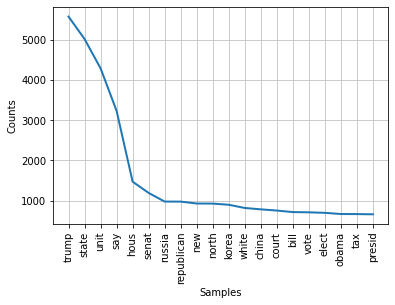

In [ ]:
# Frequency Distribution Plot - top 20
fdist_nltk_data.plot(20, cumulative=False);

In [ ]:
# use the get sentiments function on nltk processed true data
nltk_data_sentiments = get_sentiments(nltk_data_list)
nltk_data_sentiments.head()

,compound,neg,neu,pos,sentence
0,-0.1027,0.28,0.533,0.187,As United States budget fight looms Republican...
1,0.6597,0.00,0.597,0.403,United States military to accept transgender r...
2,0.4215,0.00,0.781,0.219,Senior United States Republican senator Let Mr...
3,0.0000,0.00,1.000,0.000,FBI Russia probe helped by Australian diplomat...
4,0.2449,0.00,0.835,0.165,Trump wants Postal Service to charge much more...


**Note**: This is the sentiment for the titles only! 

In [ ]:
# drop token and stop columns for nltk data and create pos, neg, neu, compound columns
# nltk_data_sent = nltk_data.drop(['token','stop'],axis=1)\
nltk_data_sent = nltk_data.assign(pos=nltk_data_sentiments['pos'])\
.assign(neg=nltk_data_sentiments['neg'])\
.assign(neu=nltk_data_sentiments['neu'])\
.assign(compound=nltk_data_sentiments['compound'])

true_sentiments = nltk_data_sent
true_sentiments.head()

,title,text,subject,date,token,stop,stem,pos,neg,neu,compound
0,As United States budget fight looms Republican...,WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017","[As, United, States, budget, fight, looms, Rep...","[As, United, States, budget, fight, looms, Rep...","[As, unit, state, budget, fight, loom, republi...",0.187,0.28,0.533,-0.1027
1,United States military to accept transgender r...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017","[United, States, military, to, accept, transge...","[United, States, military, accept, transgender...","[unit, state, militari, accept, transgend, rec...",0.403,0.00,0.597,0.6597
2,Senior United States Republican senator Let Mr...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017","[Senior, United, States, Republican, senator, ...","[Senior, United, States, Republican, senator, ...","[senior, unit, state, republican, senat, let, ...",0.219,0.00,0.781,0.4215
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017","[FBI, Russia, probe, helped, by, Australian, d...","[FBI, Russia, probe, helped, Australian, diplo...","[fbi, russia, probe, help, australian, diploma...",0.000,0.00,1.000,0.0000
4,Trump wants Postal Service to charge much more...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017","[Trump, wants, Postal, Service, to, charge, mu...","[Trump, wants, Postal, Service, charge, much, ...","[trump, want, postal, servic, charg, much, ama...",0.165,0.00,0.835,0.2449


## Fake Data *Titles*

In [ ]:
#specify dataframe here
nltk_data = df_fake

# tokenize, stem, and remove stop words
nltk_data['token'] = nltk_data['title'].apply(word_tokenize)
#stop_words = set(stopwords.words('english'))
stop_words = set(stopwords.words('english') + [punc for punc in string.punctuation])
nltk_data['stop'] = nltk_data['token'].apply(lambda x: [item for item in x if item not in stop_words])
nltk_data['stem'] = nltk_data['stop'].apply(lambda x: [ps.stem(y) for y in x])
stem_nltk_data = nltk_data['stem'].apply(pd.Series).stack()

# calculate word frequency
fdist_nltk_data = FreqDist(stem_nltk_data)

# remove punctuation counts
#for punc in string.punctuation:
#    del fdist_nltk_data[punc]

# get list of the 'content' (responses) 
nltk_data_list = list(nltk_data['title'].values)

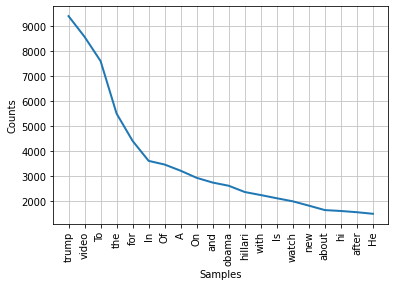

In [ ]:
# Frequency Distribution Plot - top 20
fdist_nltk_data.plot(20, cumulative=False);

In [ ]:
# use the get sentiments function on nltk processed true data
nltk_data_sentiments = get_sentiments(nltk_data_list)
nltk_data_sentiments.head()

,compound,neg,neu,pos,sentence
0,-0.7096,0.371,0.629,0.000,Donald Trump Sends Out Embarrassing New Year s...
1,-0.3400,0.255,0.745,0.000,Drunk Bragging Trump Staffer Started Russian C...
2,-0.2960,0.183,0.699,0.118,Sheriff David Clarke Becomes An Internet Joke ...
3,-0.2484,0.133,0.867,0.000,Trump Is So Obsessed He Even Has Obama s Name ...
4,0.0000,0.000,1.000,0.000,Pope Francis Just Called Out Donald Trump Duri...


**Note**: This is the sentiment for the titles only! 

In [ ]:
# drop token and stop columns for nltk data and create pos, neg, neu, compound columns
# nltk_data_sent = nltk_data.drop(['token','stop'],axis=1)\
nltk_data_sent = nltk_data.assign(pos=nltk_data_sentiments['pos'])\
.assign(neg=nltk_data_sentiments['neg'])\
.assign(neu=nltk_data_sentiments['neu'])\
.assign(compound=nltk_data_sentiments['compound'])

fake_sentiments = nltk_data_sent
fake_sentiments.head()

,title,text,subject,date,token,stop,stem,pos,neg,neu,compound
0,Donald Trump Sends Out Embarrassing New Year s...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017","[Donald, Trump, Sends, Out, Embarrassing, New,...","[Donald, Trump, Sends, Out, Embarrassing, New,...","[donald, trump, send, out, embarrass, new, yea...",0.000,0.371,0.629,-0.7096
1,Drunk Bragging Trump Staffer Started Russian C...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017","[Drunk, Bragging, Trump, Staffer, Started, Rus...","[Drunk, Bragging, Trump, Staffer, Started, Rus...","[drunk, brag, trump, staffer, start, russian, ...",0.000,0.255,0.745,-0.3400
2,Sheriff David Clarke Becomes An Internet Joke ...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017","[Sheriff, David, Clarke, Becomes, An, Internet...","[Sheriff, David, Clarke, Becomes, An, Internet...","[sheriff, david, clark, becom, An, internet, j...",0.118,0.183,0.699,-0.2960
3,Trump Is So Obsessed He Even Has Obama s Name ...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017","[Trump, Is, So, Obsessed, He, Even, Has, Obama...","[Trump, Is, So, Obsessed, He, Even, Has, Obama...","[trump, Is, So, obsess, He, even, ha, obama, n...",0.000,0.133,0.867,-0.2484
4,Pope Francis Just Called Out Donald Trump Duri...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017","[Pope, Francis, Just, Called, Out, Donald, Tru...","[Pope, Francis, Just, Called, Out, Donald, Tru...","[pope, franci, just, call, out, donald, trump,...",0.000,0.000,1.000,0.0000


# Data Exploration

### Combine data sets and label

In [ ]:
# combine and label the two sentiment data frames 
fake_labeled = fake_sentiments
fake_labeled['label'] = 0 #fake
true_labeled = true_sentiments
true_labeled['label'] = 1 #true
df_labeled = pd.concat([fake_labeled, true_labeled])

In [ ]:
# check for null data in df_labeled
df_labeled.isna().sum()

title             0
text              0
subject           0
date              0
token             0
stop              0
stem              0
pos               0
neg               0
neu               0
compound          0
label             0
num words         0
num characters    0
dtype: int64

In [ ]:
df_labeled['num words']=df_labeled['title'].str.count(' ') + 1
df_labeled['num characters'] = df_labeled['title'].str.replace(" ", "")
df_labeled['num characters'] = df_labeled['num characters'].str.len()
df_labeled

,title,text,subject,date,token,stop,stem,pos,neg,neu,compound,label,num words,num characters
0,Donald Trump Sends Out Embarrassing New Year s...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017","[Donald, Trump, Sends, Out, Embarrassing, New,...","[Donald, Trump, Sends, Out, Embarrassing, New,...","[donald, trump, send, out, embarrass, new, yea...",0.000,0.371,0.629,-0.7096,0,13,65
1,Drunk Bragging Trump Staffer Started Russian C...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017","[Drunk, Bragging, Trump, Staffer, Started, Rus...","[Drunk, Bragging, Trump, Staffer, Started, Rus...","[drunk, brag, trump, staffer, start, russian, ...",0.000,0.255,0.745,-0.3400,0,8,61
2,Sheriff David Clarke Becomes An Internet Joke ...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017","[Sheriff, David, Clarke, Becomes, An, Internet...","[Sheriff, David, Clarke, Becomes, An, Internet...","[sheriff, david, clark, becom, An, internet, j...",0.118,0.183,0.699,-0.2960,0,15,73
3,Trump Is So Obsessed He Even Has Obama s Name ...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017","[Trump, Is, So, Obsessed, He, Even, Has, Obama...","[Trump, Is, So, Obsessed, He, Even, Has, Obama...","[trump, Is, So, obsess, He, even, ha, obama, n...",0.000,0.133,0.867,-0.2484,0,15,61
4,Pope Francis Just Called Out Donald Trump Duri...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017","[Pope, Francis, Just, Called, Out, Donald, Tru...","[Pope, Francis, Just, Called, Out, Donald, Tru...","[pope, franci, just, call, out, donald, trump,...",0.000,0.000,1.000,0.0000,0,11,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21412,Fully committed NATO backs new United States a...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017","[Fully, committed, NATO, backs, new, United, S...","[Fully, committed, NATO, backs, new, United, S...","[fulli, commit, nato, back, new, unit, state, ...",0.380,0.107,0.513,0.5760,1,10,59
21413,Lexis Nexis withdrew two products from Chinese...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017","[Lexis, Nexis, withdrew, two, products, from, ...","[Lexis, Nexis, withdrew, two, products, Chines...","[lexi, nexi, withdrew, two, product, chines, m...",0.000,0.000,1.000,0.0000,1,8,46
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017","[Minsk, cultural, hub, becomes, haven, from, a...","[Minsk, cultural, hub, becomes, authorities]","[minsk, cultur, hub, becom, author]",0.000,0.000,1.000,0.0000,1,7,43
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017","[Vatican, upbeat, on, possibility, of, Pope, F...","[Vatican, upbeat, possibility, Pope, Francis, ...","[vatican, upbeat, possibl, pope, franci, visit...",0.000,0.000,1.000,0.0000,1,9,53


### Check balance of data

In [ ]:
df_labeled['label'].value_counts()

0    23481
1    21417
Name: label, dtype: int64

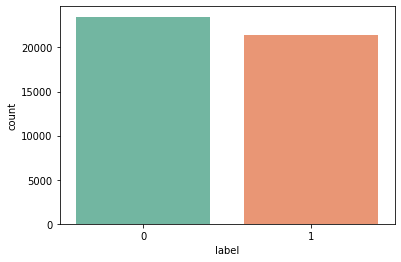

In [ ]:
sns.countplot(x="label", data=df_labeled, palette="Set2")
plt.show()

### Range and Mean of Compound Scores

In [ ]:
print('True Sentiment Compund Score Range:')
print('Min:',true_sentiments['compound'].min(),'Max:',true_sentiments['compound'].max())
print(' ')
print('True Sentiment Compund Score Mean:')
print(true_sentiments['compound'].mean())
print(' ')
print('Fake Sentiment Compund Score Range:')
print('Min:',fake_sentiments['compound'].min(),'Max:',fake_sentiments['compound'].max())
print(' ')
print('Fake Sentiment Compund Score Mean:')
print(fake_sentiments['compound'].mean())

True Sentiment Compund Score Range:
Min: -0.9403 Max: 0.9246
 
True Sentiment Compund Score Mean:
-0.0034896764252695597
 
Fake Sentiment Compund Score Range:
Min: -0.9757 Max: 0.9771
 
Fake Sentiment Compund Score Mean:
-0.17498666155615408


### Proportion of fake/true news articles with subject types

In [ ]:
subject_type = df_labeled['subject'].unique()

for subject in subject_type:
    new_df = df_labeled[df_labeled['subject'] == subject]
    fake = new_df[new_df['label'] == 'fake'].shape[0]
    true = new_df[new_df['label'] == 'true'].shape[0]
    print(f'There are {fake} fake articles with subject {subject}')

There are 0 fake articles with subject News
There are 0 fake articles with subject politics
There are 0 fake articles with subject Government News
There are 0 fake articles with subject left-news
There are 0 fake articles with subject US_News
There are 0 fake articles with subject Middle-east
There are 0 fake articles with subject politicsNews
There are 0 fake articles with subject worldnews


In [ ]:
subject_type = df_labeled['subject'].unique()

for subject in subject_type:
    new_df = df_labeled[df_labeled['subject'] == subject]
    fake = new_df[new_df['label'] == 'fake'].shape[0]
    true = new_df[new_df['label'] == 'true'].shape[0]
    print(f'There are {true} true articles with subject {subject}')

There are 0 true articles with subject News
There are 0 true articles with subject politics
There are 0 true articles with subject Government News
There are 0 true articles with subject left-news
There are 0 true articles with subject US_News
There are 0 true articles with subject Middle-east
There are 0 true articles with subject politicsNews
There are 0 true articles with subject worldnews


#### It looks like the two data sets were labled with completely different 'subjects' 🤔

### TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
vectorizer = CountVectorizer(analyzer = 'word', max_features = 2000, tokenizer = word_tokenize, 
                             stop_words = stopwords.words('english'))

In [ ]:
X = vectorizer.fit_transform(df_labeled['title']).toarray()
y = np.array(df_labeled['label'])
X

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [ ]:
from google.colab import files

# Add the data of the form [X, y] & save
Xy_array = np.hstack([X, y.reshape(-1,1)])

np.save('data.npy', Xy_array)
files.download('data.npy')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tfidf = TfidfVectorizer(sublinear_tf = True, analyzer = 'word', max_features = 2000, tokenizer = word_tokenize)
tfidf_X = tfidf.fit_transform(df_labeled['title']).toarray()
tfidf_X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.35842321, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
# export the data
from google.colab import files
df_labeled.to_csv("df_labeled.csv")
files.download("df_labeled.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>